In [3]:
import numpy as np
import pandas as pd
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint, adfuller

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='whitegrid')

Stationarity/ Non Stationarity

In [4]:
def generate_data(params):
    mu = params[0]
    sigma = params[1]
    return np.random.normal(mu, sigma)

Text(0.5, 1.0, 'Non-Stationary')

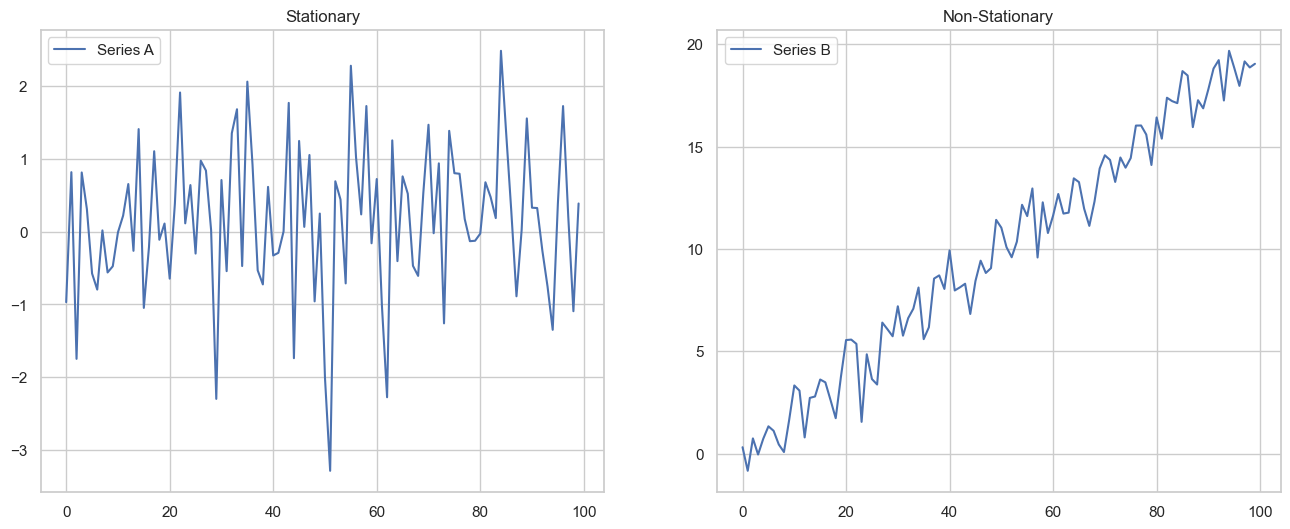

In [9]:
params = (0,1)
T = 100

A = pd.Series()
A.name = 'A'

for t in range(T):
    A[t] = generate_data(params)
    
B = pd.Series()
B.name= 'B'

for t in range(T):
    params = (t*0.2, 1)
    B[t] = generate_data(params)
    
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, figsize=(16,6))

ax1.plot(A)
ax2.plot(B)
ax1.legend(['Series A'])
ax2.legend(['Series B'])
ax1.set_title('Stationary')
ax2.set_title('Non-Stationary')



Augmented Dickey Fuller - testing unit root

In [16]:
def stationarity_test(X, cut_off = 0.01):
    pvalue = adfuller(X)[1]
    if pvalue < cut_off:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely stationary.')
    else:
        print('p-value = ' + str(pvalue) + ' The series ' + X.name +' is likely non-stationary.')


In [17]:
stationarity_test(A)
stationarity_test(B)

p-value = 1.707692902732919e-18 The series A is likely stationary.
p-value = 0.8116096289566097 The series B is likely non-stationary.


Cointegration

<Axes: >

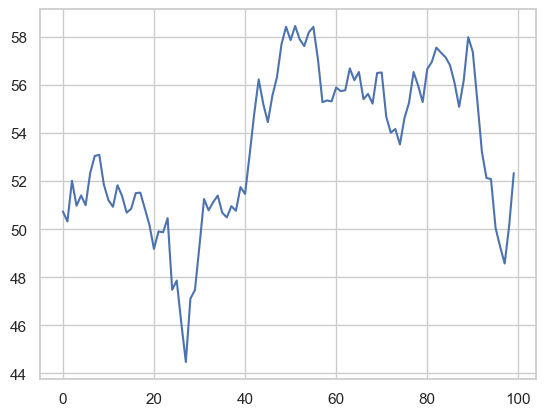

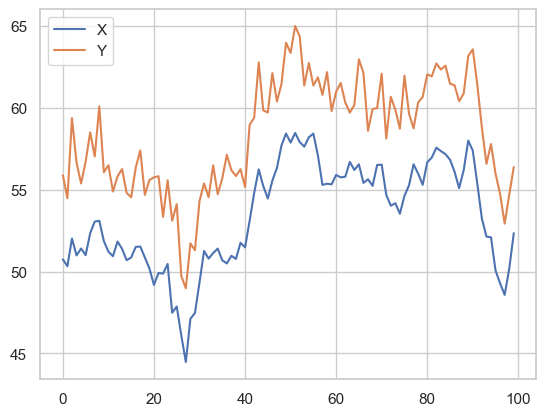

In [40]:
Xreturns = np.random.normal(0, 1, 100)

X = pd.Series(np.cumsum(Xreturns), name = 'X') + 50

Y = X + 5 + np.random.normal(0,1,100)
Y.name = 'Y'

plt.plot(X)

pd.concat([X,Y], axis = 1).plot()

In [41]:
score, pvalue, _ = coint(X,Y)
pvalue

8.441580469016339e-14

Real life data

In [45]:
pd.core.common.is_list_like = pd.api.types.is_list_like
from pandas_datareader import data as pdr
import datetime
import yfinance as yf

In [46]:
def find_cointegrated_pairs(data):
    n = data.shape[1]
    score_matrix = np.zeros((n,n))
    pvalue_matrix = np.ones((n,n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1,n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.05:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs
    

In [54]:
start = datetime.datetime(2013, 1, 1)
end = datetime.datetime(2019, 1, 1)

tickers = ['AAPL', 'ADBE', 'ORCL', 'EBAY', 'MSFT', 'QCOM', 'HPQ', 'JNPR', 'AMD', 'IBM', 'SPY']

df = yf.download(tickers, start, end)['Close']
df.tail()

[*********************100%***********************]  11 of 11 completed


Ticker,AAPL,ADBE,AMD,EBAY,HPQ,IBM,JNPR,MSFT,ORCL,QCOM,SPY
Date,,,,,,,,,,,
2018-12-24,36.707500,205.160004,16.650000,26.139999,19.379999,102.839386,25.559999,94.129997,42.689999,53.650002,234.339996
2018-12-26,39.292500,222.949997,17.900000,27.850000,20.330000,106.491394,26.600000,100.559998,44.590000,55.959999,246.179993
2018-12-27,39.037498,225.139999,17.490000,28.030001,20.379999,108.776291,26.799999,101.180000,44.970001,56.090000,248.070007
2018-12-28,39.057499,223.130005,17.820000,28.240000,20.340000,108.059273,26.750000,100.389999,44.820000,56.810001,247.750000
2018-12-31,39.435001,226.240005,18.459999,28.070000,20.459999,108.671127,26.910000,101.570000,45.150002,56.910000,249.919998


[('AAPL', 'ORCL'), ('AAPL', 'SPY'), ('ADBE', 'MSFT'), ('AMD', 'MSFT'), ('HPQ', 'ORCL'), ('ORCL', 'SPY')]


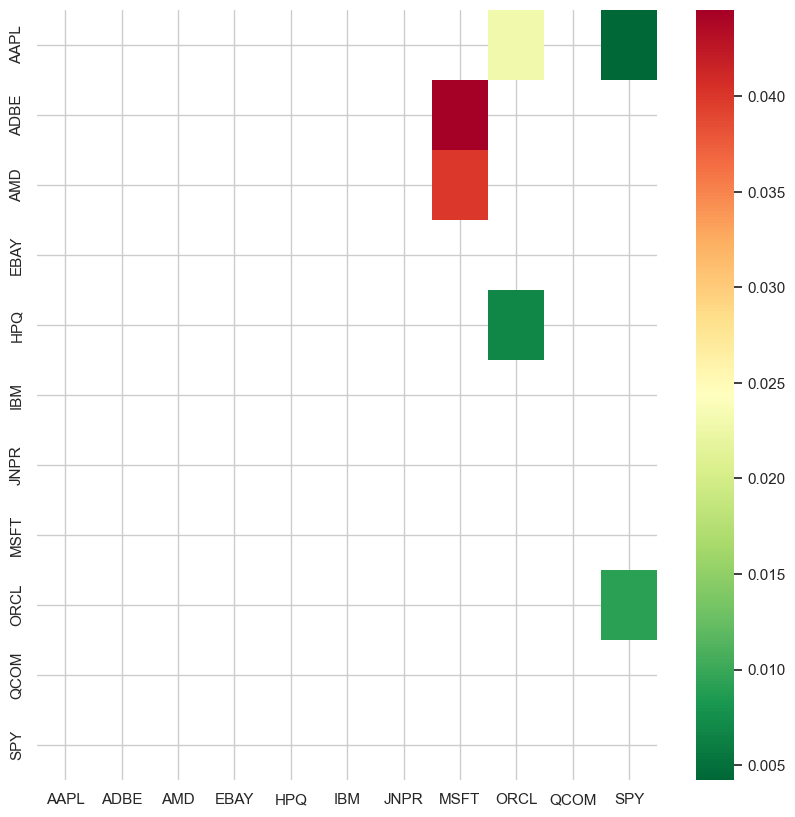

In [55]:
scores, pvalues, pairs = find_cointegrated_pairs(df)
import seaborn
fig, ax = plt.subplots(figsize=(10,10))
seaborn.heatmap(pvalues, xticklabels=df.columns, yticklabels=df.columns, cmap='RdYlGn_r'
                , mask = (pvalues >= 0.05)
                )
print(pairs)